# ml lab7

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 1. load dataset & prepare data

In [57]:
import tensorflow as tf
import tensorflow_datasets as tfds

DATASET_NAME = 'imdb_reviews/subwords8k'

data, info = tfds.load(DATASET_NAME, as_supervised=True, with_info=True)

print(info.homepage)

data

http://ai.stanford.edu/~amaas/data/sentiment/


{'test': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'train': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>,
 'unsupervised': <PrefetchDataset shapes: ((None,), ()), types: (tf.int64, tf.int64)>}

In [61]:
encoder = info.features['text'].encoder
train = data['train']
test = data['test']
encoder

<SubwordTextEncoder vocab_size=8185>

In [118]:
for train_example, train_label in train.take(10):
    encoded = train_example[:10].numpy()
    sentense = encoder.decode(encoded)
    label = '👍' if train_label.numpy() else '😥'
    print(f'[{label}] {sentense.ljust(50)}\t', encoded)

[😥] This was an absolutely terrible movie. Don't      	 [  62   18   41  604  927   65    3  644 7968   21]
[😥] I have been known to fall asleep during films     	 [  12   31   93  867    7 1256 6585 7961  421  365]
[😥] Mann photographs the Alberta Rocky Mo             	 [ 636  102 4714    8    1 4333    4 4135   47 1325]
[👍] This is the kind of film for a snowy              	 [  62    9    1  312    6   32   23    4 7809   47]
[👍] As others have mentioned, all the women that      	 [ 249  929   31 2699  104    2   51    1  707   13]
[👍] This is a film which should be seen by anybody    	 [  62    9    4   32   73  180   35  165   43 6104]
[😥] Okay, you have:<br /><br />Pen                    	 [4344    2   37 2876 4541   10   16   10   17 4056]
[😥] The film is based on a genuine 1950s novel        	 [  19   32    9  659   25    4 6295 3537    8 1334]
[😥] I really love the sexy action and sci-fi          	 [  12   81  174    1 4004  328    5 1429 7974 2470]
[😥] Sure, this one isn't rea

In [96]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

def cook_data(ds):
    return ds.shuffle(BUFFER_SIZE).padded_batch(BATCH_SIZE, padded_shapes=([None], []))

In [63]:
train_dataset = cook_data(train)
test_dataset = cook_data(test)

### 2. build lstm network

In [217]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional

def build_model(emb=Embedding(encoder.vocab_size, 64)):
    model = Sequential()
    
    model.add(emb)
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [71]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          523840    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               66048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 590,017
Trainable params: 590,017
Non-trainable params: 0
_________________________________________________________________


In [72]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_steps=20,
    epochs=10,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/10
391/391 [==============================] - 157s 400ms/step - loss: 0.5432 - accuracy: 0.7332 - val_loss: 0.5166 - val_accuracy: 0.7625
Epoch 2/10
391/391 [==============================] - 154s 393ms/step - loss: 0.4722 - accuracy: 0.7981 - val_loss: 0.4312 - val_accuracy: 0.8180
Epoch 3/10
391/391 [==============================] - 153s 392ms/step - loss: 0.5086 - accuracy: 0.7640 - val_loss: 0.4674 - val_accuracy: 0.7969
Epoch 4/10
391/391 [==============================] - 153s 391ms/step - loss: 0.5015 - accuracy: 0.7589 - val_loss: 0.5117 - val_accuracy: 0.7742
Epoch 5/10
391/391 [==============================] - 153s 390ms/step - loss: 0.4229 - accuracy: 0.8217 - val_loss: 0.6028 - val_accuracy: 0.6570
Epoch 6/10
391/391 [==============================] - 154s 393ms/step - loss: 0.3718 - accuracy: 0.8406 - val_loss: 0.4421 - val_accuracy: 0.8086
Epoch 7/10
391/391 [==============================] - 154s 394ms/step - loss: 0.2858 - accuracy: 0.8919 - val_loss: 0.4342 -

In [75]:
def evaluate(model, history):
    results = model.evaluate(test_dataset)
    print(f'\nTrain accuracy: {history.history["accuracy"][-1]*100:.2f}%')
    print(f'Test accuracy: {results[-1]*100:.2f}%')

In [76]:
evaluate(model, history)

    391/Unknown - 44s 112ms/step - loss: 0.4392 - accuracy: 0.8309
Train accuracy: 89.19%
Test accuracy: 83.09%


In [77]:
def plot(_history):    
    plt.figure(figsize=(8, 6))
    plt.plot(_history.history['accuracy'], 'r')
    plt.plot(_history.history['val_accuracy'], 'b')
    plt.legend(['Training', 'Validation'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

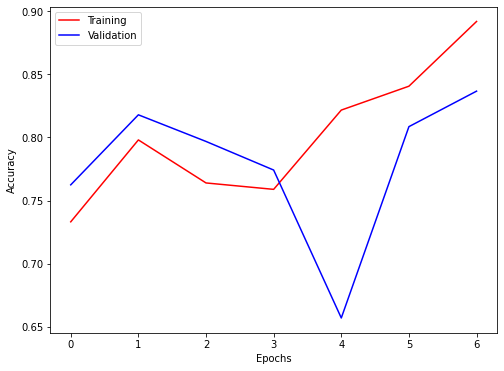

In [78]:
plot(history)

### 3. glove embeddings

In [158]:
!./download_data.sh

data/glove-global-vectors-for-word-representation already exist


In [213]:
DATA_DIR='data'

EMBEDDING_DIM = 200
VOCAB_SIZE = encoder.vocab_size

GLOVE_NAME=f'glove.6B.{EMBEDDING_DIM}d.txt'
GLOVE_PATH=f'{DATA_DIR}/glove-global-vectors-for-word-representation/{GLOVE_NAME}'

In [169]:
embeddings_index = {}

with open(GLOVE_PATH, 'r') as glove_file:
    for line in glove_file:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Found {len(embeddings_index)} word vectors.')

Found 400000 word vectors.


In [209]:
def clean(s):
    return s.lower().replace('_', '')

In [214]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
fails = 0

for i, word in enumerate(encoder.subwords, 1):
    embedding_vector = embeddings_index.get(clean(word))
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        fails += 1

In [215]:
print(f'Found embeddings for {(VOCAB_SIZE - fails) / VOCAB_SIZE:.2%} of vocab')

Found embeddings for 92.12% of vocab


In [218]:
model = build_model(
    Embedding(encoder.vocab_size, EMBEDDING_DIM, weights=[embedding_matrix], trainable=False)
)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 200)         1637000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               135680    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 1,772,809
Trainable params: 135,809
Non-trainable params: 1,637,000
_________________________________________________________________


In [222]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_steps=20,
    epochs=10,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/10
391/391 [==============================] - 220s 563ms/step - loss: 0.5072 - accuracy: 0.7546 - val_loss: 0.6268 - val_accuracy: 0.6609
Epoch 2/10
391/391 [==============================] - 222s 567ms/step - loss: 0.4915 - accuracy: 0.7686 - val_loss: 0.3832 - val_accuracy: 0.8297
Epoch 3/10
391/391 [==============================] - 221s 565ms/step - loss: 0.3864 - accuracy: 0.8401 - val_loss: 0.3647 - val_accuracy: 0.8406
Epoch 4/10
391/391 [==============================] - 219s 561ms/step - loss: 0.3643 - accuracy: 0.8514 - val_loss: 0.3742 - val_accuracy: 0.8422
Epoch 5/10
391/391 [==============================] - 221s 566ms/step - loss: 0.3434 - accuracy: 0.8586 - val_loss: 0.3246 - val_accuracy: 0.8648
Epoch 6/10
391/391 [==============================] - 220s 563ms/step - loss: 0.3259 - accuracy: 0.8666 - val_loss: 0.3315 - val_accuracy: 0.8680
Epoch 7/10
391/391 [==============================] - 221s 565ms/step - loss: 0.3096 - accuracy: 0.8744 - val_loss: 0.3442 -

In [223]:
evaluate(model, history)

    391/Unknown - 59s 150ms/step - loss: 0.3075 - accuracy: 0.8707
Train accuracy: 89.01%
Test accuracy: 87.07%


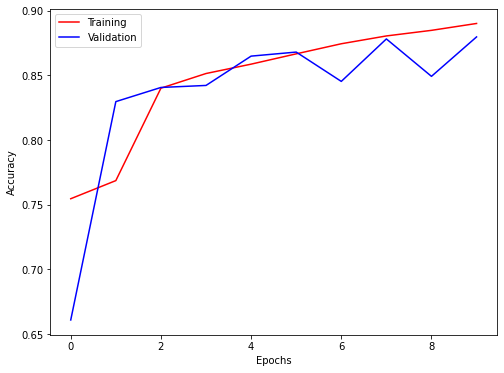

In [224]:
plot(history)

### 4. more layers with gru

In [230]:
from tensorflow.keras.layers import GRU

def build_model():
    model = Sequential()
    
    model.add(Embedding(VOCAB_SIZE, 100))
    model.add(Bidirectional(GRU(64, return_sequences=True), merge_mode='concat'))
    model.add(Bidirectional(GRU(64), merge_mode='concat'))
    model.add(Dense(64, activation='elu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

In [231]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 100)         818500    
_________________________________________________________________
bidirectional_9 (Bidirection (None, None, 128)         63744     
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 128)               74496     
_________________________________________________________________
dense_9 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 965,061
Trainable params: 965,061
Non-trainable params: 0
________________________________________________

In [238]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    validation_steps=20,
    epochs=5,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/5
391/391 [==============================] - 349s 894ms/step - loss: 0.6053 - accuracy: 0.7049 - val_loss: 0.8399 - val_accuracy: 0.6422
Epoch 2/5
391/391 [==============================] - 353s 903ms/step - loss: 0.5501 - accuracy: 0.7666 - val_loss: 1.1302 - val_accuracy: 0.5797
Epoch 3/5
391/391 [==============================] - 355s 909ms/step - loss: 0.5090 - accuracy: 0.7957 - val_loss: 0.7684 - val_accuracy: 0.6203
Epoch 4/5
391/391 [==============================] - 353s 903ms/step - loss: 0.6021 - accuracy: 0.7615 - val_loss: 0.8636 - val_accuracy: 0.7148
Epoch 5/5
391/391 [==============================] - 353s 903ms/step - loss: 0.8848 - accuracy: 0.8023 - val_loss: 0.9502 - val_accuracy: 0.6562


In [239]:
evaluate(model, history)

    391/Unknown - 86s 220ms/step - loss: 1.0037 - accuracy: 0.6556
Train accuracy: 80.23%
Test accuracy: 65.56%


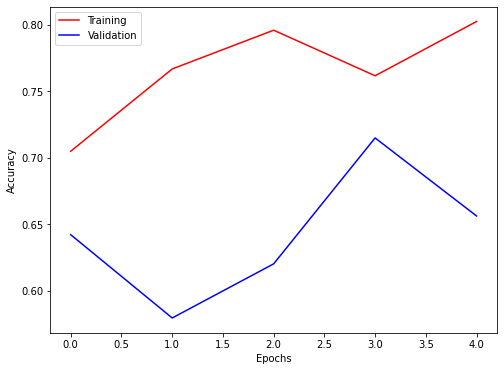

In [240]:
plot(history)